
# MMF1921/MIE377 Style Backtesting Template

From the MIE377/MMF1921 Projects:

        The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

        This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

        # PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

This template for evaluating asset allocation algorithms is the exact same style as the one in MIE377.

Is it fast? No it is not.

Is it clear and relatively easy to follow? Yes it is.

There are a couple of moving parts:

* The database: see the Database folder for examples of where and how the data was processed. Download SQLLite viewer to explore the data and look at the queries in the notebooks to understand what data is in there
* The services: in the services folder there are some helpers to extract the data (data_retrieval.py), estimate means and covariances (estimators.py), and optimizers (optimization.py)
* Strategies are also defined in the services folder. The current convention is that a strategy takes in data (returns and factor returns) and outputs an allocation.
* Typically, the strategies will use some form of estimator and an optimizer come up with allocations.

If you do not want to deal with the database then use the MIE377_Project_Main template and copy cells 2.1 and 2.2 into the appropriate spot
and replace 

        x[:,t] = project_function(periodReturns, periodFactRet)

with

        x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

# 1. Read input files

In [148]:
import time
import math
from Database.services.database import Database
from sqlalchemy import inspect
from services.data_retreival import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.strategies import *
from services.optimization_layers import *

Database.initialize("sqlite:///Database//financial_db.sqlite") #for courses replace this with a flat file
inspector = inspect(Database.engine)
print(inspector.get_table_names())

universe = 'ETF'
imputation_method = 'Multivariate'
#exponential params
k = 6*20
alpha=1 - 0.995

adjClose = pd.read_csv("flat_files/MonthlyAssetPrices"+ universe + ".csv", index_col=0, header = 1).iloc[1:,:]

daily_adjClose =  pd.read_csv("flat_files/DailyAssetPrices"+universe + ".csv", index_col=0, header = 1).iloc[1:,:]

TechnicalAnalysis = pd.read_csv("flat_files/TechnicalAnalysis" + universe + ".csv", index_col=[0,1])

if universe ==  'SP':
    FinancialRatios = pd.read_csv("flat_files/" + imputation_method + "WRDS.csv", index_col=[0,1])
    TechnicalAnalysis.index.names = FinancialRatios.index.names
    ContextualInfo = TechnicalAnalysis.merge(FinancialRatios, how = 'inner', left_index=True, right_index=True)

else:
    TechnicalAnalysis.index.names = ['date', 'ticker']
    ContextualInfo = TechnicalAnalysis


['asset_id', 'currency_id', 'equities_series', 'equity_index_id', 'exchange_id', 'factor_id', 'factors', 'frequency_id', 'fundamentals', 'metric_id', 'source_id', 'ticker_id', 'ticker_index_membership', 'tiingo_tickers']


In [149]:
adjClose.index = pd.to_datetime(adjClose.index, format='%Y-%m-%d').tz_localize(None)
daily_adjClose.index = pd.to_datetime(daily_adjClose.index, format='%Y-%m-%d').tz_localize(None)
ContextualInfo.index = ContextualInfo.index.set_levels([pd.to_datetime(ContextualInfo.index.levels[0]).tz_localize(None), ContextualInfo.index.levels[1]])

In [150]:
print("The earliest possible start date")
max(daily_adjClose.index.unique()[0], ContextualInfo.index.get_level_values('date').unique()[0], adjClose.index.unique()[0])

The earliest possible start date


Timestamp('2006-01-31 00:00:00')

In [151]:
print("The latest possible start date")
min(daily_adjClose.index.unique()[-1], ContextualInfo.index.get_level_values('date').unique()[-1], adjClose.index.unique()[-1])

The latest possible start date


Timestamp('2023-04-21 00:00:00')

In [152]:
# start_date = pd.to_datetime('1996-11-30', format = '%Y-%m-%d')
#
# end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

start_date = pd.to_datetime('2006-05-31', format = '%Y-%m-%d')

end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

factors = ('Mkt-RF', 'RF')

factorRet = get_monthly_factors(factors, start_date, end_date, Database)

factorRet = factorRet.droplevel(0, axis = 1)
factorRet.columns = [col.strip() for col in factorRet.columns]

In [153]:
adjClose = adjClose[start_date:end_date]
daily_adjClose = daily_adjClose[start_date:end_date]
idx = pd.IndexSlice
ContextualInfo = ContextualInfo.loc[idx[start_date:end_date, :], :]

In [154]:
# Initial budget to invest ($100,000)
initialVal = 100000

# Length of investment period (in months) - but actually units of data
investPeriod = 6

# divide the factor returns by 100
factorRet = factorRet/100

#rf and factor returns
#drop the first observation to align the dataset with the returns data that will
#result
factorRet = factorRet.iloc[1:, :]

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

In [155]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [156]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values) # risk adjusted returns
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [157]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Run your program

This section will run your Project1_Function in a loop. The data will be loaded progressively as a growing window of historical observations.
Rebalancing will take place after every loop

### 2.1 Some Standard Allocation Strategies

In [158]:

class general_strategy:
    """
    a general strategy where the estimator and optimizer are specified, makes all the other strategies obsolete
    """

    def __init__(self, estimator, optimizer, NumObs=36, investor_preferences=None):
        if investor_preferences is None:
            investor_preferences = {}
        self.NumObs = NumObs  # number of observations to use
        self.estimator = estimator  # estimator is a function
        self.optimizer = optimizer
        self.investor_preferences = investor_preferences #kappa, K, q, epsilon, C, turnover limit
        self.additional_estimation_info=None
        self.additional_optimization_info=None
    def execute_strategy(self, periodReturns, factorReturns):
        """
        executes the portfolio allocation strategy based on the parameters in the __init__

        :param additional_optimization_info:
        :param additional_estimation_info:
        :param additional_info:
        :param factorReturns:
        :param periodReturns:
        :return:x
        """
        additional_estimation_info= self.additional_estimation_info
        additional_optimization_info= self.additional_optimization_info

        T, n = periodReturns.shape
        # get the last T observations
        returns = periodReturns.iloc[(-1) * self.NumObs:, :]
        factRet = factorReturns.iloc[(-1) * self.NumObs:, :]
        if additional_estimation_info is None:
            estimates = self.estimator(returns, factRet)
        else:
            estimates = self.estimator(**additional_estimation_info)

        if additional_optimization_info is None:
            x = self.optimizer(*estimates, **self.investor_preferences)
        else:
            x = self.optimizer(*estimates, **self.investor_preferences,  **additional_optimization_info)
        return x

In [159]:
#Some strategies (uncomment this or the next cell to pick a strategy to test)
# Strategy = general_strategy(sample_estimator, MVO, NumObs=48)  #the general strategy object takes an estimator function and an optimizer function
#                                                                #the only constraint is that the estimators outputs are the optimizers inputs

Strategy = general_strategy(exponential_weighted_estimator, MVO)

def populate_exponential_weighted_estimator(Strategy, k, alpha, period_daily_adjClose):
    additional_estimation_info = {}
    additional_estimation_info['k'] = k
    additional_estimation_info['alpha'] = alpha
    additional_estimation_info['daily_prices'] = period_daily_adjClose
    Strategy.additional_estimation_info = additional_estimation_info

#exponential_weighted_estimator(daily_prices, k, alpha=1 - 0.985)
# see strategy script for different options OLS_RP() #OLS_MVO() #HistoricalMeanVarianceOptimization()

In [160]:
# Start of out-of-sample test period
testStart = returns.index[0] + pd.offsets.DateOffset(years=3)

#End of the first investment period
#testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days = 1)
testEnd = testStart + pd.offsets.MonthBegin(investPeriod) - pd.offsets.DateOffset(days = 1)

# End of calibration period
calEnd = testStart -  pd.offsets.DateOffset(days = 1)

In [161]:
print("Test Start", testStart)
print("Test End", testEnd)
print("Calibration End", calEnd)

Test Start 2009-06-30 00:00:00
Test End 2009-11-30 00:00:00
Calibration End 2009-06-29 00:00:00


In [162]:
# Total number of investment periods
NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

In [163]:
# Number of assets
n  = len(tickers)

# Preallocate space for the portfolio weights (x0 will be used to calculate
# the turnover rate)
x  = np.zeros([n, NoPeriods])
x0 = np.zeros([n, NoPeriods])

# Preallocate space for the portfolio per period value and turnover
currentVal = np.zeros([NoPeriods, 1])
turnover   = np.zeros([NoPeriods, 1])

#Initiate counter for the number of observations per investment period
toDay = 0

# Measure runtime: start the clock
start_time = time.time()

# Empty list to measure the value of the portfolio over the period
portfValue = []

for t in range(NoPeriods):
    # Subset the returns and factor returns corresponding to the current calibration period.
    periodReturns = returns[returns.index <= calEnd]
    periodFactRet = factorRet[factorRet.index <= calEnd]

    #take the last available contextual observations
    period_daily_adjClose = daily_adjClose[daily_adjClose.index <= calEnd]
    period_Context_idx = ContextualInfo.index.get_level_values('date') <= calEnd
    period_Context = ContextualInfo.iloc[period_Context_idx].groupby('ticker').last()

    #there should be a feature vector for each asset
    assert len(period_Context) == n

    current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
    currentPrices = adjClose[current_price_idx]

    # Subset the prices corresponding to the current out-of-sample test period.
    periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
    periodPrices = adjClose[periodPrices_idx]

    assert len(periodPrices) == investPeriod
    assert len(currentPrices) == 1
    # Set the initial value of the portfolio or update the portfolio value
    if t == 0:
        currentVal[0] = initialVal
    else:
        currentVal[t] = currentPrices @  NoShares.values.T
        #Store the current asset weights (before optimization takes place)
        x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

    #----------------------------------------------------------------------
    # Portfolio optimization
    # You must write code your own algorithmic trading function
    #----------------------------------------------------------------------
    # add in the estimation info
    populate_exponential_weighted_estimator(Strategy, k, alpha, period_daily_adjClose)

    x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

    #Calculate the turnover rate
    if t > 0:
        turnover[t] = np.sum(np.abs( x[:,t] - x0[:,t] ) )

    # Number of shares your portfolio holds per stock
    NoShares = x[:,t]*currentVal[t]/currentPrices

    # Update counter for the number of observations per investment period
    fromDay = toDay
    toDay   = toDay + len(periodPrices)

    # Weekly portfolio value during the out-of-sample window
    portfValue.append(periodPrices@ NoShares.values.T)

    # Update your calibration and out-of-sample test periods
    testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
    testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
    calEnd    = testStart - pd.offsets.DateOffset(days=1)

portfValue = pd.concat(portfValue, axis = 0)
end_time = time.time()

C:\Users\david\anaconda3\envs\svmmvo\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


# 3. Results

In [164]:
#--------------------------------------------------------------------------
# 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
#-----------------------------------------------------------------------
# Calculate the observed portfolio returns
portfRets = portfValue.pct_change(1).iloc[1:,:]

# Calculate the portfolio excess returns
portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

# Calculate the portfolio Sharpe ratio
SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

# Calculate the average turnover rate
avgTurnover = np.mean(turnover[1:])

#Print Sharpe ratio and Avg. turnover to the console
print("Elasped time is "+ str(end_time - start_time) + ' seconds')
print('Sharpe ratio: ', str(SR[0]))
print('Avg. turnover: ', str(avgTurnover))

Elasped time is 14.95653772354126 seconds
Sharpe ratio:  0.2061805920506319
Avg. turnover:  1.0315359755206481


### Observations

        The end to end strategy has the following stats when we use 15 observations:
        Elasped time is 27.749337434768677 seconds
        Sharpe ratio:  0.36926056542515073
        Avg. turnover:  0.2846570354951544

        Standard MVO has the following stats when we use 15 observations::
        
        Elasped time is 1.1906468868255615 seconds
        Sharpe ratio:  0.35584233976844887
        Avg. turnover:  0.6967647038270909

        The end to end strategy has the following stats when we use 35 observations:
        
        Elasped time is 16.95100688934326 seconds
        Sharpe ratio:  0.33129478714103455
        Avg. turnover:  0.13229814142751284

        Standard MVO has the following stats when we use 35 observations:
        
        Elasped time is 1.2436742782592773 seconds
        Sharpe ratio:  0.2997765726515852
        Avg. turnover:  0.25328429647155937


<Figure size 640x480 with 0 Axes>

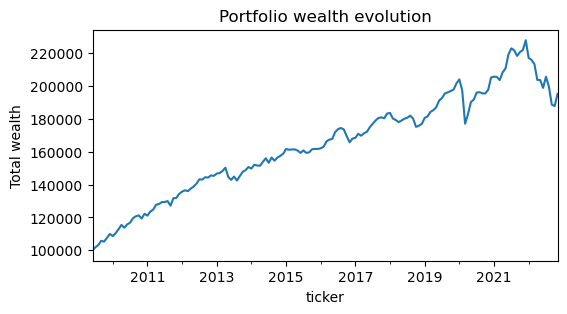

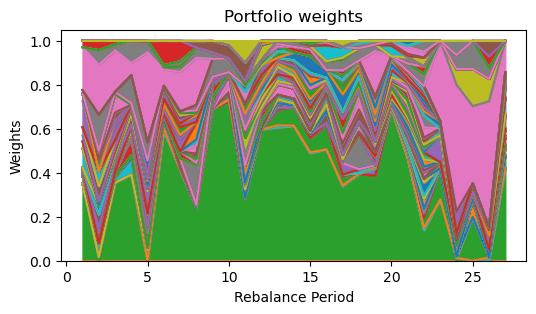

In [165]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = False)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2);
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]
if n <= 20:
    legend_bool = True
else:
    legend_bool = False
weights.T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = legend_bool, stacked = True)
if legend_bool:
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights.svg");
#
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End

### 0.12% maximum absolute difference between the returns generated via Python and returns generated via MATLAB can be observed

### Terminal wealth between MATLAB and Python is within 0.1%

In [166]:
weights.iloc[:, 0].sort_values()

RQI    1.705335e-12
JRS    2.493256e-12
RNP    2.559855e-12
DSU    2.975706e-12
PFD    3.036208e-12
           ...     
NOM    3.895424e-02
MIN    8.813808e-02
NXN    1.178078e-01
TIP    1.954697e-01
AGG    3.508302e-01
Name: 1, Length: 299, dtype: float64

In [167]:
(np.abs(daily_adjClose.diff().dropna()) <= 0.001).sum().sort_values()

IWM      9
IJH     10
MDY     10
VBK     11
SPY     12
      ... 
DHF    696
CIF    704
BHV    710
MIN    710
NOM    823
Length: 299, dtype: int64

In [168]:
daily_adjClose['SPYG']

ticker
2006-05-31     9.845561
2006-06-01    10.001681
2006-06-02    10.023698
2006-06-05     9.807532
2006-06-06     9.811535
                ...    
2022-12-23    50.425508
2022-12-27    50.049050
2022-12-28    49.424923
2022-12-29    50.276906
2022-12-30    50.197652
Name: SPYG, Length: 4177, dtype: float64

In [169]:
portfExRets

,0
ticker,
2009-07-31,0.017857
2009-08-31,0.012794
2009-09-30,0.025440
2009-10-31,-0.004831
2009-11-30,0.022072
...,...
2022-07-31,0.033367
2022-08-31,-0.030772
2022-09-30,-0.056999


In [170]:
# Calculate the portfolio Sharpe ratio
spy_rets = adjClose[['AGG', 'SPYG']].pct_change(1).iloc[1:,]
spy_rets = spy_rets.loc[portfRets.index]

spyExRets = spy_rets.subtract(riskFree[(riskFree.index >= spy_rets.index[0])&(riskFree.index <= spy_rets.index[-1])], axis = 0)

spySR = ((spyExRets + 1).apply(gmean, axis=0) - 1)/spyExRets.std()


In [171]:
spySR

AGG     0.134475
SPYG    0.251982
dtype: float64

In [133]:
type(spyExRets)

pandas.core.frame.DataFrame